In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle competitions download -c hackathon-online-nlu-intent-classification

  0% 0.00/389k [00:00<?, ?B/s]
100% 389k/389k [00:00<00:00, 105MB/s]


In [3]:
!unzip /content/hackathon-online-nlu-intent-classification.zip
!rm /content/hackathon-online-nlu-intent-classification.zip

Archive:  /content/hackathon-online-nlu-intent-classification.zip
  inflating: intent_sample_submission.csv  
  inflating: small_test.csv          
  inflating: test.csv                
  inflating: train.json              
  inflating: valid.json              


In [4]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.7 MB/s eta 0:00:00


In [5]:
!pip install transformers

In [6]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=852d0a87629bcc4e3dfd33a239e142324155890aca4c220deffb51d9b76117c4
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [7]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix
import pickle
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout,Embedding,Conv1D, GlobalMaxPooling1D, Flatten, MaxPooling1D,Bidirectional,TimeDistributed,LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall

In [8]:
df_train= pd.read_json('train.json')
df_train

,utterance,slots,intent
0,will it be rainy in tenino,O O O B-condition_description O B-city,GetWeather
1,add steve albini album to my psychedelic rock ...,O B-artist I-artist B-music_item O B-playlist_...,AddToPlaylist
2,book a table for 3 at one of the restaurants i...,O O O O B-party_size_number O O O O B-restaura...,BookRestaurant
3,what s the weather forecast for belknap,O O O O O O B-city,GetWeather
4,play fereydoun farrokhzad best track,O B-artist I-artist B-sort B-music_item,PlayMusic
...,...,...,...
13079,show me the lights out saga,O O O B-object_name I-object_name B-object_type,SearchCreativeWork
13080,what is a weather of martinique a month from now,O O O O O B-country B-timeRange I-timeRange I-...,GetWeather
13081,i d like to reserve a spot at a bakery in guya...,O O O O O O O O O B-restaurant_type O B-countr...,BookRestaurant
13082,please find me the work serious awesomeness,O O O O O B-object_name I-object_name,SearchCreativeWork


In [9]:
df_valid= pd.read_json('valid.json')
df_valid

,utterance,slots,intent
0,i d like to see the show onion sportsdome,O O O O O O B-object_type B-object_name I-obje...,SearchCreativeWork
1,give the current book 4 stars,O O B-object_select B-object_type B-rating_val...,RateBook
2,reserve a table for 8 in neighboring hitchland,O O O O B-party_size_number O B-spatial_relati...,BookRestaurant
3,show creative video game the boat is full,O O B-object_type I-object_type B-object_name ...,SearchCreativeWork
4,put once bitten twice bitten into the pulse of...,O B-entity_name I-entity_name I-entity_name I-...,AddToPlaylist
...,...,...,...
195,what is the forecast for 6 am in aruba,O O O O O B-timeRange I-timeRange O B-country,GetWeather
196,add my very best to my road trip playlist,O B-entity_name I-entity_name I-entity_name O ...,AddToPlaylist
197,looking for liberalism and the limits of justice,O O B-object_name I-object_name I-object_name ...,SearchCreativeWork
198,what s the closest movie house showing night i...,O O O B-spatial_relation B-object_location_typ...,SearchScreeningEvent


In [10]:
df_test= pd.read_csv('test.csv')
df_test

,id,utterance
0,1,add this tune to my playlist guest list mashable
1,2,i d like to listen to the song the natural farmer
2,3,i need a table for 8 people at a restaurant in...
3,4,open the canciones del recuerdo playlist and p...
4,5,i want to hear something from the top-fifty by...
...,...,...
295,296,show weather forecast in west wildwood south c...
296,297,add this track to the playlist hits of the 70s
297,298,i want to eat at a food truck this week with m...
298,299,rate company for gertrude 4 of 6


# 1. EDA

In [ ]:
utterance_counts = df_train['intent'].value_counts().reset_index()
utterance_counts.columns = ['intent', 'count']


fig = px.bar(utterance_counts, x='intent', y='count', text='count', labels={'count':'Count of Intent'})
fig.update_traces(texttemplate='%{text}', textposition='outside')

fig.update_layout(
    xaxis_title='Intent',
    yaxis_title='Count',
    title='Count of Each Intent',
    xaxis_tickangle=-45
)

fig.show()

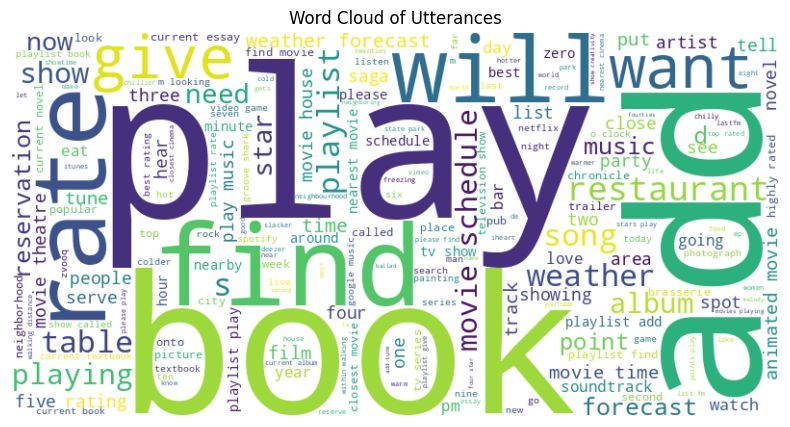

In [ ]:
all_utterances = ' '.join(df_train['utterance'])


wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_utterances)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Utterances')
plt.show()

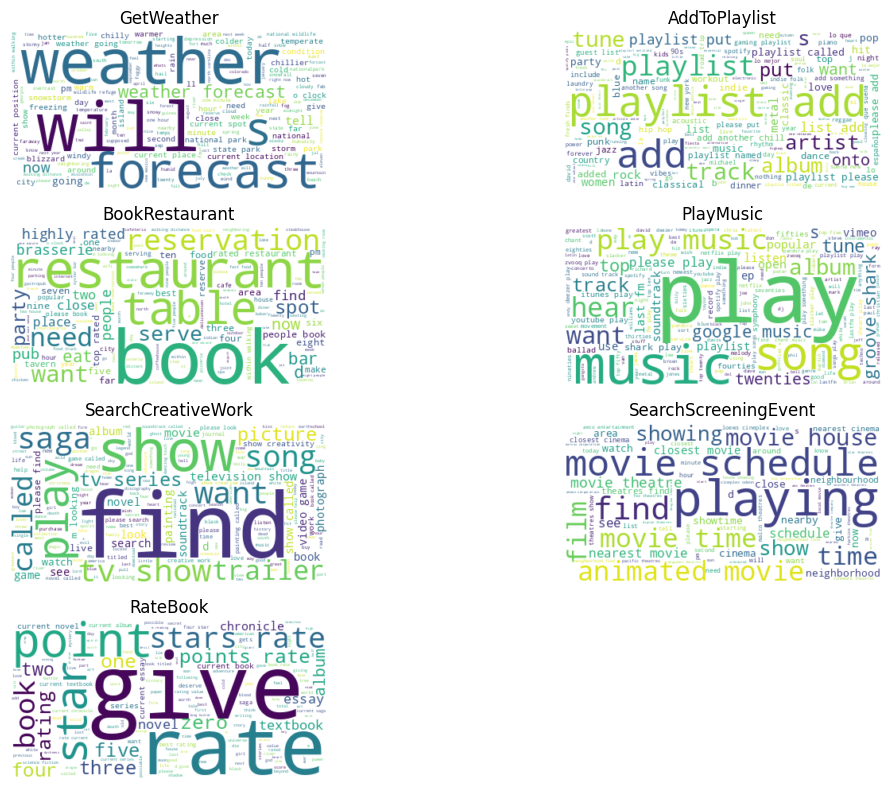

In [ ]:
intents = df_train['intent'].unique()


n_rows = (len(intents) + 1) // 2
n_cols = 2


fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))

for i, intent in enumerate(intents):
    row = i // n_cols
    col = i % n_cols


    utterances_for_intent = df_train[df_train['intent'] == intent]['utterance']

    all_utterances = ' '.join(utterances_for_intent)


    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(all_utterances)


    axes[row, col].imshow(wordcloud, interpolation='bilinear')
    axes[row, col].set_title(intent)
    axes[row, col].axis('off')


if len(intents) % 2 != 0:
    fig.delaxes(axes[n_rows - 1, n_cols - 1])

plt.tight_layout()
plt.show()

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
all_utterances = ' '.join(df_train['utterance'])

words = re.findall(r'\b\w+\b', all_utterances.lower())


stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words]

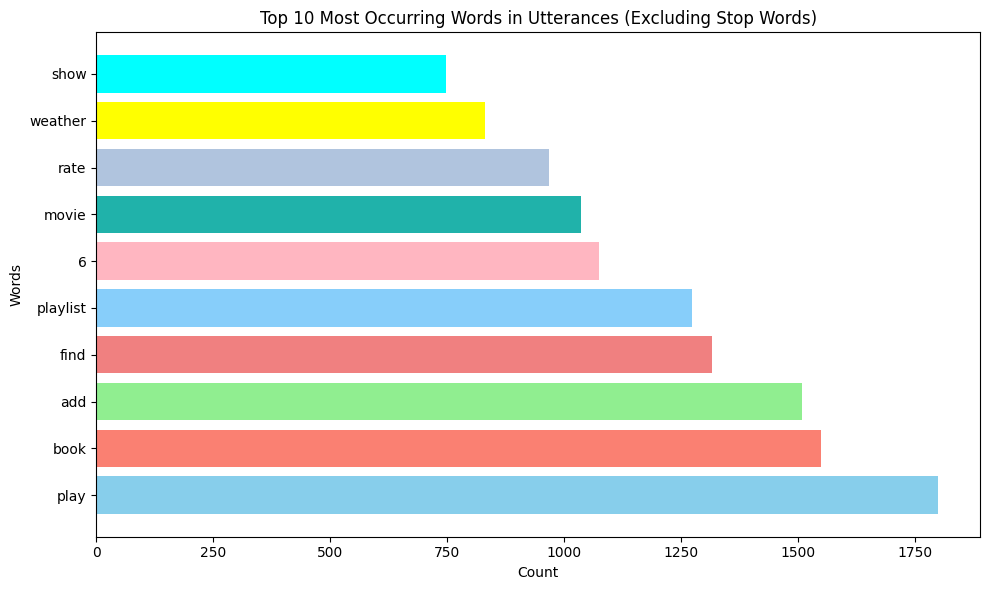

In [ ]:
word_counts = Counter(filtered_words)

top_10_words = word_counts.most_common(10)


top_words, counts = zip(*top_10_words)


colors = ['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'lightskyblue',
          'lightpink', 'lightseagreen', 'lightsteelblue', 'yellow', 'cyan']


plt.figure(figsize=(10, 6))
plt.barh(top_words, counts, color=colors)
plt.title('Top 10 Most Occurring Words in Utterances (Excluding Stop Words)')
plt.xlabel('Count')
plt.ylabel('Words')
plt.tight_layout()

plt.show()

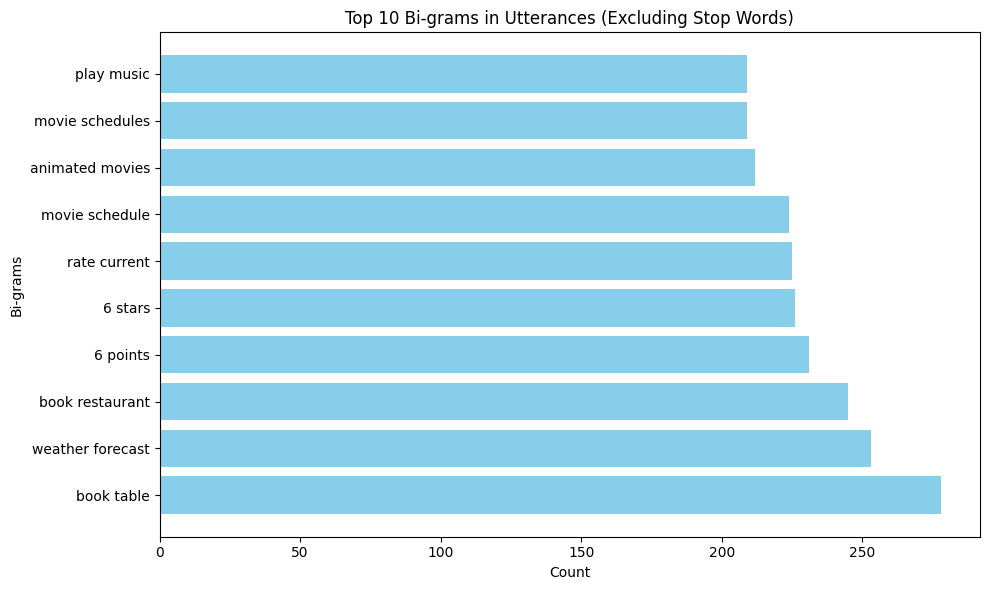

In [ ]:
bi_grams = list(ngrams(filtered_words, 2))


bi_gram_counts = Counter(bi_grams)


top_10_bi_grams = bi_gram_counts.most_common(10)


top_bi_grams, counts = zip(*top_10_bi_grams)


top_bi_gram_strings = [' '.join(gram) for gram in top_bi_grams]


plt.figure(figsize=(10, 6))
plt.barh(top_bi_gram_strings, counts, color='skyblue')
plt.title('Top 10 Bi-grams in Utterances (Excluding Stop Words)')
plt.xlabel('Count')
plt.ylabel('Bi-grams')
plt.tight_layout()

plt.show()

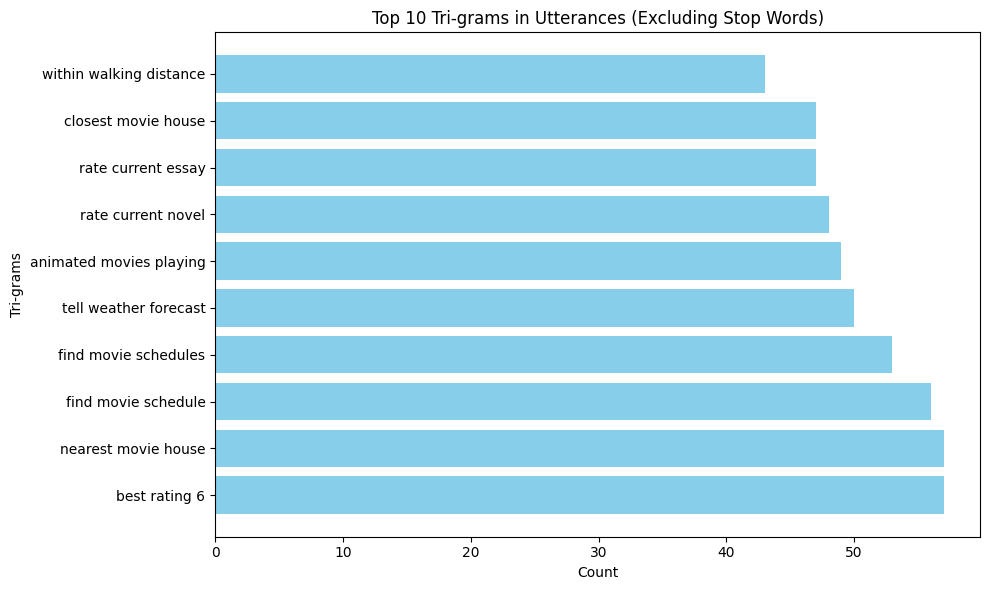

In [ ]:
tri_grams = list(ngrams(filtered_words, 3))


tri_gram_counts = Counter(tri_grams)


top_10_tri_grams = tri_gram_counts.most_common(10)


top_tri_grams, counts = zip(*top_10_tri_grams)


top_tri_gram_strings = [' '.join(gram) for gram in top_tri_grams]


plt.figure(figsize=(10, 6))
plt.barh(top_tri_gram_strings, counts, color='skyblue')
plt.title('Top 10 Tri-grams in Utterances (Excluding Stop Words)')
plt.xlabel('Count')
plt.ylabel('Tri-grams')
plt.tight_layout()

plt.show()

In [ ]:
unique_slot_classes = set()


for row in df_train['slots']:
    slots = row.split()
    for slot in slots:
        if slot != 'O':
            unique_slot_classes.add(slot)

unique_slot_classes_list = list(unique_slot_classes)


unique_slot_classes_list

['I-party_size_description',
 'I-object_type',
 'I-movie_name',
 'B-rating_unit',
 'I-current_location',
 'B-condition_temperature',
 'I-facility',
 'I-playlist',
 'I-album',
 'I-served_dish',
 'B-object_select',
 'B-music_item',
 'B-condition_description',
 'B-sort',
 'I-country',
 'I-object_name',
 'I-spatial_relation',
 'I-genre',
 'B-artist',
 'B-restaurant_type',
 'B-poi',
 'I-location_name',
 'B-object_part_of_series_type',
 'B-entity_name',
 'B-party_size_number',
 'I-object_part_of_series_type',
 'I-artist',
 'B-country',
 'I-cuisine',
 'I-object_location_type',
 'B-object_name',
 'B-geographic_poi',
 'B-movie_type',
 'B-object_location_type',
 'I-service',
 'B-spatial_relation',
 'B-current_location',
 'B-track',
 'B-timeRange',
 'I-poi',
 'B-playlist',
 'B-genre',
 'I-music_item',
 'I-sort',
 'I-state',
 'B-city',
 'B-playlist_owner',
 'B-movie_name',
 'B-rating_value',
 'B-best_rating',
 'I-track',
 'I-geographic_poi',
 'B-facility',
 'B-object_type',
 'B-served_dish',
 'I-t

In [ ]:
print(len(unique_slot_classes_list))

71


In [ ]:
model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

(…)o/bert-base-cased/resolve/main/vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

(…)t-base-cased/resolve/main/tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

(…)bert-base-cased/resolve/main/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

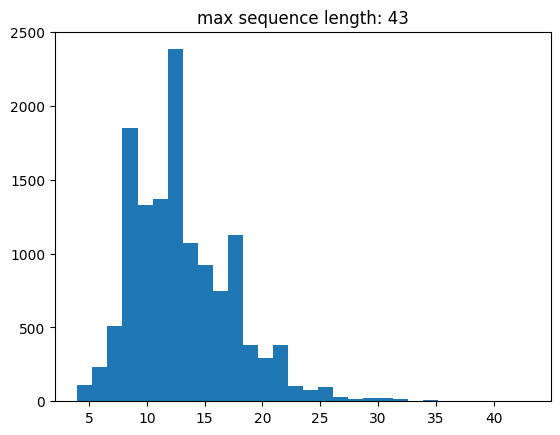

In [ ]:
train_sequence_lengths = [len(tokenizer.encode(text))
                          for text in df_train["utterance"]]
plt.hist(train_sequence_lengths, bins=30)
plt.title(f"max sequence length: {max(train_sequence_lengths)}");

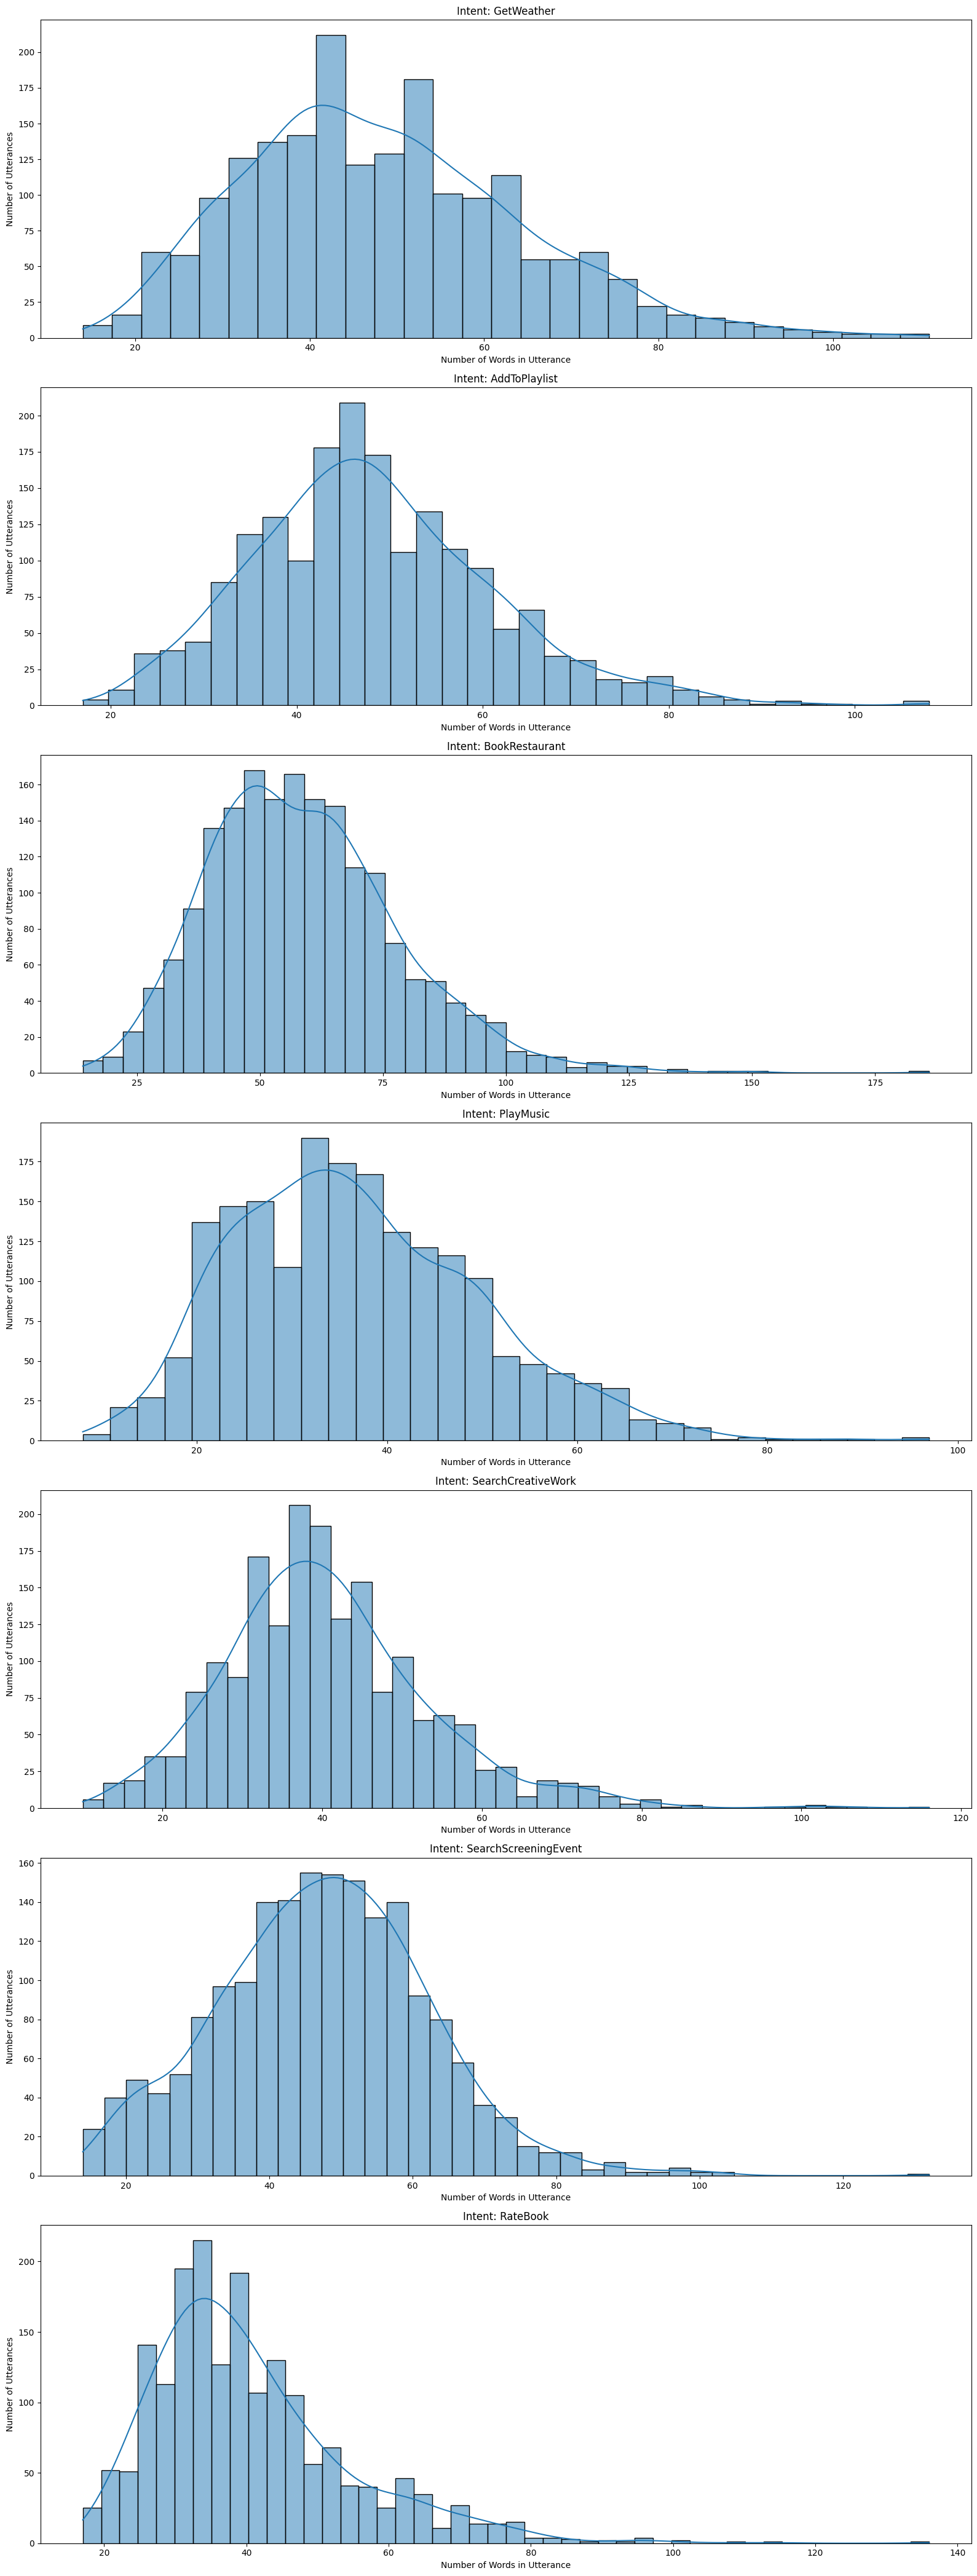

In [ ]:
unique_intents = df_train['intent'].unique()


fig, axes = plt.subplots(len(unique_intents), figsize=(16, 6 * len(unique_intents)))

for i, intent in enumerate(unique_intents):
    tmp= df_train.copy()
    tmp['numwords'] = tmp['utterance'].apply(lambda x: len(x))
    tmp = tmp[tmp['intent'] == intent]

    ax = axes[i]
    sns.histplot(data=tmp, x='numwords', kde=True, ax=ax)
    ax.set_title(f'Intent: {intent}')
    ax.set_xlabel('Number of Words in Utterance')
    ax.set_ylabel('Number of Utterances')

plt.tight_layout()
plt.show()

# 2. Intent Classification

- 2.1 Multinomial Naive Bayes

In [ ]:
train_texts = df_train['utterance'].tolist()
train_intents = df_train['intent'].tolist()

valid_texts = df_valid['utterance'].tolist()
valid_intents = df_valid['intent'].tolist()

In [ ]:
le = LabelEncoder()
train_encoded_intents = le.fit_transform(train_intents)
valid_encoded_intents = le.transform(valid_intents)

In [ ]:
with open(os.path.join("/content/", 'labelencoder.pkl'),'wb') as file:
  pickle.dump(le,file)

In [ ]:
vectorizer = TfidfVectorizer()
train_encoded_inputs = vectorizer.fit_transform(train_texts)
valid_encoded_inputs = vectorizer.transform(valid_texts)

In [ ]:
with open(os.path.join("/content/", 'vectorizer.pkl'),'wb') as file:
  pickle.dump(vectorizer,file)

In [ ]:
X_train= train_encoded_inputs.toarray()
y_train = train_encoded_intents

In [ ]:
X_valid= valid_encoded_inputs .toarray()
y_valid= valid_encoded_intents

In [ ]:
X_train.shape, y_train.shape

((13084, 11014), (13084,))

In [ ]:
parameters = {
            "alpha": [50, 15, 10, 5, 1, 0.5, 0.3, 0.1, 0.05, 0.03, 0.02, 0.01,  0.001],
            "fit_prior": [True, False],
            }
est= MultinomialNB()
kf = StratifiedKFold(n_splits=10)
mnb= GridSearchCV(estimator=est,
                      param_grid=parameters,
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=kf)

In [ ]:
mnb.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [50, 15, 10, 5, 1, 0.5, 0.3, 0.1, 0.05, 0.03,
                                   0.02, 0.01, 0.001],
                         'fit_prior': [True, False]},
             scoring='accuracy')

In [ ]:
print(mnb.best_params_)
print(mnb.best_estimator_)
print(mnb.best_score_)

{'alpha': 1, 'fit_prior': True}
MultinomialNB(alpha=1)
0.9773005866233065


In [ ]:
y_pred_valid= mnb.predict(X_valid)

In [ ]:
accuracy = accuracy_score(y_valid, y_pred_valid)
print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 0.97


In [ ]:
report = classification_report(y_valid, y_pred_valid)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        29
           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00        35
           3       1.00      0.94      0.97        32
           4       1.00      1.00      1.00        20
           5       0.94      0.91      0.93        35
           6       0.90      0.96      0.93        27

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



- Artificial Neural Network

In [ ]:
X_test=X_valid
y_test=y_valid

NameError: ignored

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [ ]:
def build_ann_model():
    model = Sequential()

    model.add(Dense(units=1024, activation="relu", input_dim=X_train.shape[1]))
    model.add(BatchNormalization())

    model.add(Dense(units=512, activation="relu"))
    model.add(Dropout(0.3))

    model.add(Dense(units=256, activation="relu"))
    model.add(BatchNormalization())

    model.add(Dense(units=len(np.unique(y_train)) , activation="softmax"))

    optimizer = Adam(learning_rate=0.000015, beta_1=0.9, beta_2=0.999)

    model.compile(optimizer=optimizer, metrics=["accuracy"], loss="sparse_categorical_crossentropy")


    checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_loss', save_best_only=True)

    return model, checkpoint

In [ ]:
model, checkpoint_callback = build_ann_model()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_loss', save_best_only=True)

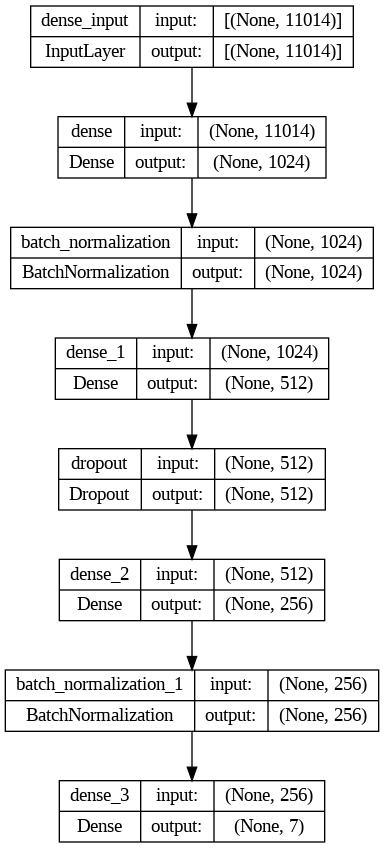

In [ ]:
plot_model(model,show_shapes=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              11279360  
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                       

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=256,
                    validation_data=(X_valid, y_valid), callbacks=[checkpoint_callback,stop_early])

Epoch 1/10
41/41 [==============================] - 34s 832ms/step - loss: 0.1713 - accuracy: 0.9671 - val_loss: 1.1644 - val_accuracy: 0.6947
Epoch 2/10
41/41 [==============================] - 31s 751ms/step - loss: 0.1453 - accuracy: 0.9746 - val_loss: 0.9474 - val_accuracy: 0.7914
Epoch 3/10
41/41 [==============================] - 33s 813ms/step - loss: 0.1271 - accuracy: 0.9817 - val_loss: 0.7441 - val_accuracy: 0.8621
Epoch 4/10
41/41 [==============================] - 31s 759ms/step - loss: 0.1103 - accuracy: 0.9829 - val_loss: 0.5731 - val_accuracy: 0.9026
Epoch 5/10
41/41 [==============================] - 48s 1s/step - loss: 0.0970 - accuracy: 0.9862 - val_loss: 0.4440 - val_accuracy: 0.9259
Epoch 6/10
41/41 [==============================] - 24s 591ms/step - loss: 0.0842 - accuracy: 0.9904 - val_loss: 0.3526 - val_accuracy: 0.9331
Epoch 7/10
41/41 [==============================] - 20s 494ms/step - loss: 0.0774 - accuracy: 0.9914 - val_loss: 0.2906 - val_accuracy: 0.9408
Ep

- 2.2 ANN with hyperparameter tuning

In [ ]:
def build_ann_model(hp):
    model = Sequential()

    model.add(Dense(units=1024, activation="relu", input_dim=X_train.shape[1]))
    model.add(BatchNormalization())

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units, activation="relu"))
    model.add(Dropout(0.3))

    model.add(Dense(units=256, activation="relu"))
    model.add(BatchNormalization())

    model.add(Dense(units=len(np.unique(y_train)) , activation="softmax"))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = Adam(learning_rate=hp_learning_rate, beta_1=0.9, beta_2=0.999)

    model.compile(optimizer=optimizer,
                  metrics=['accuracy'],
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

    return model

In [ ]:
tuner = kt.Hyperband(build_ann_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128 and the optimal learning rate for the optimizer
is 0.001.



In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_loss', save_best_only=True)

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50,validation_data=(X_valid, y_valid), callbacks=[checkpoint_callback,stop_early])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



328/328 [==============================] - 88s 260ms/step - loss: 0.2106 - accuracy: 0.9367 - val_loss: 0.5682 - val_accuracy: 0.9476
Epoch 2/50
328/328 [==============================] - ETA: 0s - loss: 0.0650 - accuracy: 0.9783

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



328/328 [==============================] - 96s 292ms/step - loss: 0.0650 - accuracy: 0.9783 - val_loss: 0.0902 - val_accuracy: 0.9717
Epoch 3/50
328/328 [==============================] - 86s 261ms/step - loss: 0.0261 - accuracy: 0.9914 - val_loss: 0.1293 - val_accuracy: 0.9679
Epoch 4/50
328/328 [==============================] - 83s 254ms/step - loss: 0.0256 - accuracy: 0.9924 - val_loss: 0.1022 - val_accuracy: 0.9725
Epoch 5/50
328/328 [==============================] - 87s 265ms/step - loss: 0.0149 - accuracy: 0.9957 - val_loss: 0.1199 - val_accuracy: 0.9729
Epoch 6/50
328/328 [==============================] - 84s 255ms/step - loss: 0.0120 - accuracy: 0.9965 - val_loss: 0.1260 - val_accuracy: 0.9759
Epoch 7/50
328/328 [==============================] - 88s 269ms/step - loss: 0.0091 - accuracy: 0.9976 - val_loss: 0.1218 - val_accuracy: 0.9767
Best epoch: 7


In [ ]:
ypred = model.predict(X_test)

7/7 [==============================] - 1s 65ms/step


In [ ]:
ann_accuracy = accuracy_score(y_test,ypred.argmax(axis=-1))
print("ANN Accuracy:",ann_accuracy)

ANN Accuracy: 0.975


In [ ]:
report = classification_report(y_test, ypred.argmax(axis=-1))
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        22
           2       0.97      0.97      0.97        35
           3       0.94      1.00      0.97        32
           4       0.95      1.00      0.98        20
           5       0.97      0.94      0.96        35
           6       1.00      0.93      0.96        27

    accuracy                           0.97       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.97      0.97       200



- 2.3 Convolutional neural network (CNN)

In [34]:
X_train= df_train['utterance']
y_train= df_train['intent']
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

X_test = df_valid['utterance']
y_test = df_valid['intent']

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_valid= label_encoder.transform(y_valid)
y_test= label_encoder.transform(y_test)


print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_valid:", y_valid.shape)
print("y_test:", y_test.shape)

X_train: (10467,)
X_valid: (2617,)
X_test: (200,)
y_train: (10467,)
y_valid: (2617,)
y_test: (200,)


In [35]:
tokenizer = Tokenizer(num_words=100000,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True)
tokenizer.fit_on_texts(X_train)

In [36]:
vocab_size = len(tokenizer.index_word) + 1
print('Vocab Size:', vocab_size)

Vocab Size: 9643


In [37]:
X_train_token = tokenizer.texts_to_sequences(X_train)
X_valid_token = tokenizer.texts_to_sequences(X_valid)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [38]:
sequence_len = 50
X_train_token = pad_sequences(X_train_token, padding='post', maxlen=sequence_len)
X_valid_token = pad_sequences(X_valid_token, padding='post', maxlen=sequence_len)
X_test_token = pad_sequences(X_test_token, padding='post', maxlen=sequence_len)

In [39]:
def build_cnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=sequence_len))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(units=len(np.unique(y_train)) , activation="softmax"))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)

    return model

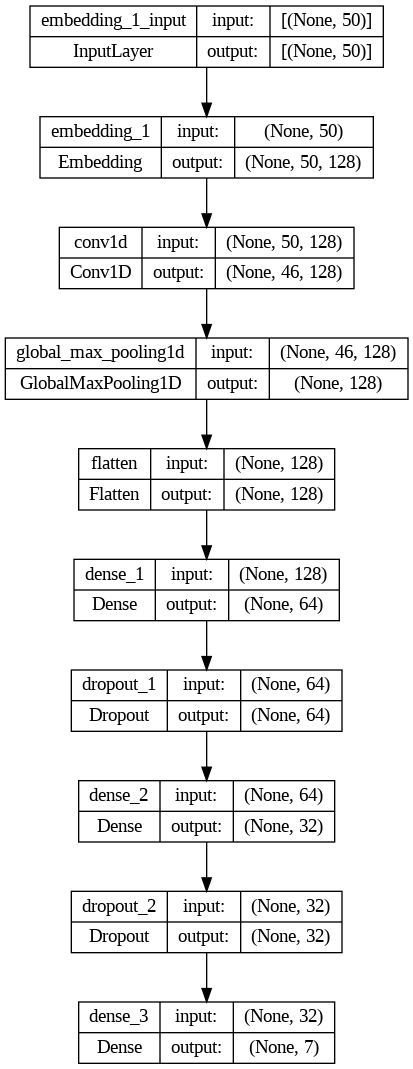

In [40]:
cnn = build_cnn_model()
plot_model(cnn,show_shapes=True)

In [41]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           1234304   
                                                                 
 conv1d (Conv1D)             (None, 46, 128)           82048     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

In [42]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_loss', save_best_only=True)

In [43]:
history = cnn.fit(X_train_token, y_train, epochs=20, batch_size=256,
                    validation_data=(X_valid_token , y_valid), callbacks=[checkpoint,stop_early])

Epoch 1/20
41/41 [==============================] - 6s 142ms/step - loss: 2.6891 - accuracy: 0.4341 - val_loss: 1.8551 - val_accuracy: 0.8101
Epoch 2/20
 1/41 [..............................] - ETA: 5s - loss: 1.9722 - accuracy: 0.6211

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 7s 165ms/step - loss: 1.3433 - accuracy: 0.7862 - val_loss: 0.7594 - val_accuracy: 0.9629
Epoch 3/20
41/41 [==============================] - 7s 173ms/step - loss: 0.7005 - accuracy: 0.9437 - val_loss: 0.4910 - val_accuracy: 0.9786
Epoch 4/20
41/41 [==============================] - 7s 164ms/step - loss: 0.4621 - accuracy: 0.9742 - val_loss: 0.3592 - val_accuracy: 0.9832
Epoch 5/20
41/41 [==============================] - 6s 139ms/step - loss: 0.3412 - accuracy: 0.9832 - val_loss: 0.2837 - val_accuracy: 0.9843
Epoch 6/20
41/41 [==============================] - 6s 157ms/step - loss: 0.2617 - accuracy: 0.9886 - val_loss: 0.2367 - val_accuracy: 0.9851
Epoch 7/20
41/41 [==============================] - 6s 146ms/step - loss: 0.2185 - accuracy: 0.9894 - val_loss: 0.2120 - val_accuracy: 0.9824
Epoch 8/20
41/41 [==============================] - 7s 164ms/step - loss: 0.1825 - accuracy: 0.9926 - val_loss: 0.1840 - val_accuracy: 0.9843
Epoch 9/20
41/41 

In [44]:
ypred = cnn.predict(X_test_token)

7/7 [==============================] - 0s 7ms/step


In [45]:
cnn_accuracy = accuracy_score(y_test,ypred.argmax(axis=-1))
print("CNN Accuracy:",cnn_accuracy)

CNN Accuracy: 0.985


In [46]:
report = classification_report(y_test, ypred.argmax(axis=-1))
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00        35
           3       0.97      0.97      0.97        32
           4       1.00      1.00      1.00        20
           5       0.97      0.94      0.96        35
           6       0.96      1.00      0.98        27

    accuracy                           0.98       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.98      0.98       200



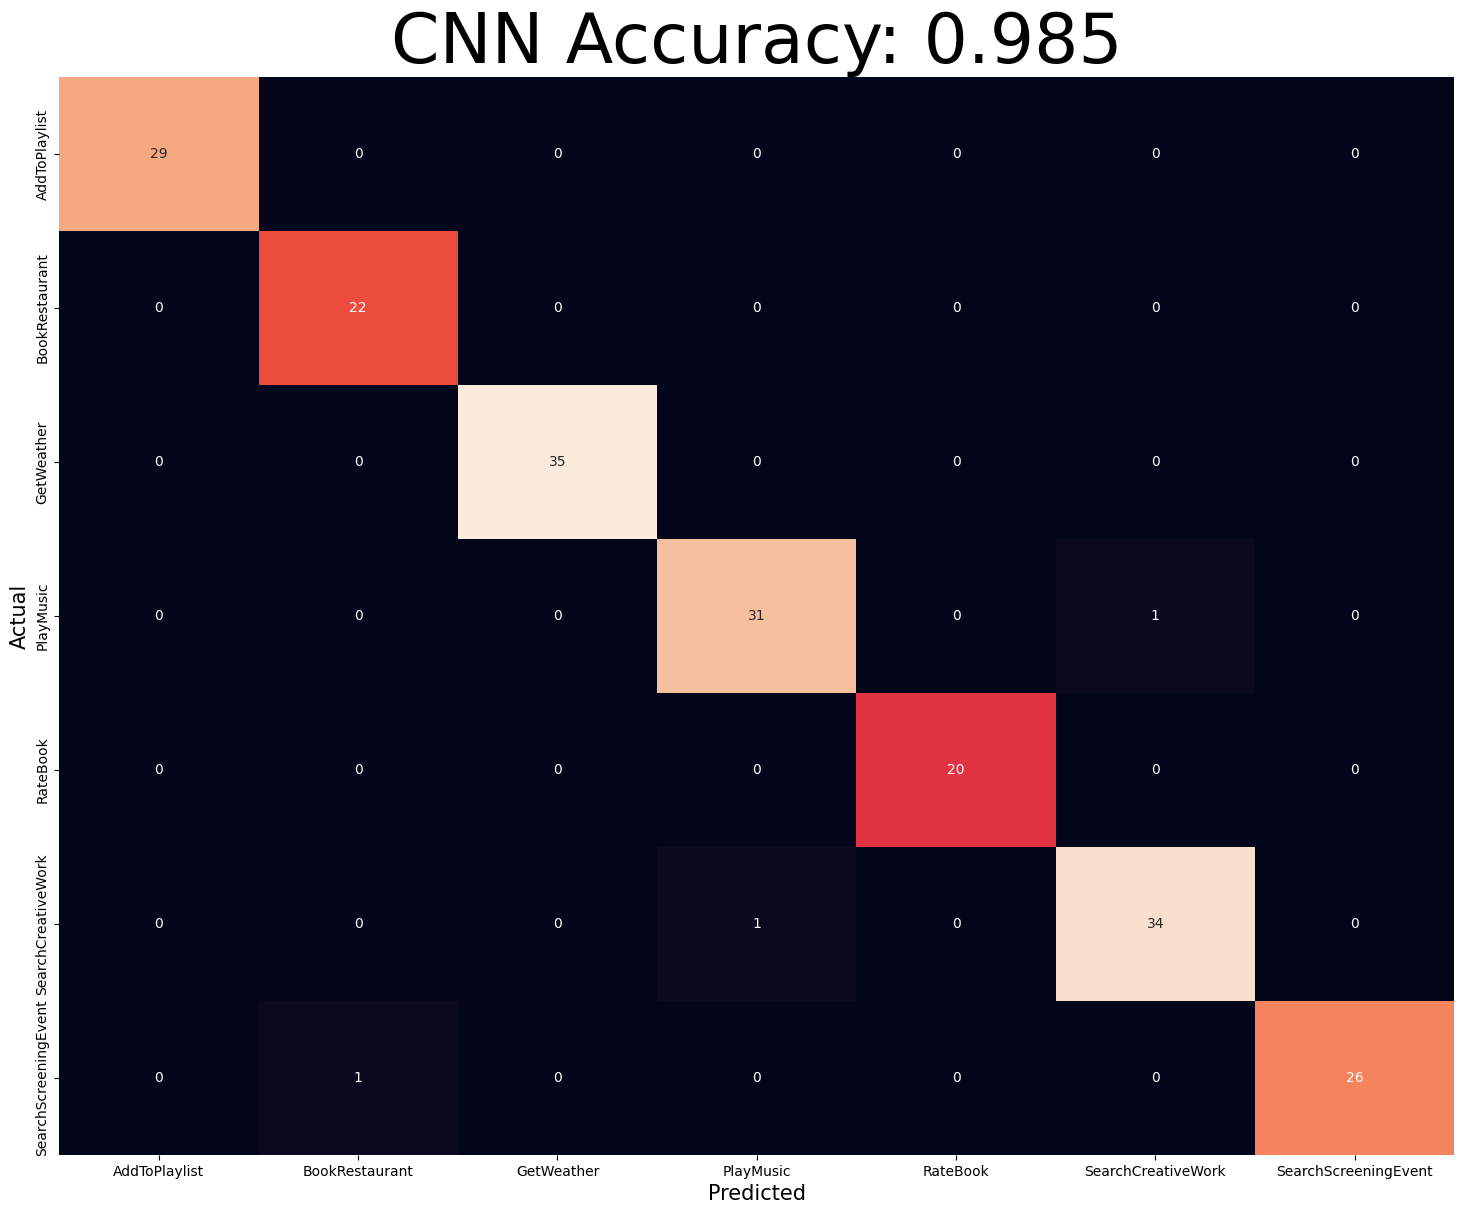

In [26]:
cnn_cn = confusion_matrix(y_test,ypred.argmax(axis=-1))
plt.subplots(figsize=(18,14))
sns.heatmap(cnn_cn,annot=True,fmt="1d",cbar=False,xticklabels=label_encoder.classes_,yticklabels=label_encoder.classes_)
plt.title("CNN Accuracy: {}".format(cnn_accuracy),fontsize=50)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
plt.show()

In [46]:
with open('cnn_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
def predict_intent(sentence):
    sentence_sequence = tokenizer.texts_to_sequences([sentence])
    sentence_sequence_padded = pad_sequences(sentence_sequence, padding='post', maxlen=50)

    predictions = cnn.predict(sentence_sequence_padded)

    predicted_label = np.argmax(predictions)
    label=label_encoder.classes_[predicted_label]
    return label

In [48]:
predict_intent("Hey, I'm looking forward to the new movie screening of 'Avengers: Endgame' at the local theater on November 25th, 2023")

1/1 [==============================] - 0s 25ms/step


'SearchScreeningEvent'

# 3.Slot Filling

In [11]:
X_train= df_train['utterance']
y_train= df_train['slots']
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

X_test = df_valid['utterance']
y_test = df_valid['slots']


print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_valid:", y_valid.shape)
print("y_test:", y_test.shape)

X_train: (10467,)
X_valid: (2617,)
X_test: (200,)
y_train: (10467,)
y_valid: (2617,)
y_test: (200,)


In [12]:
unique_labels = y_train.str.split().explode().unique()
num_unique_labels = len(unique_labels)

print(f"Number of unique labels in y_train: {num_unique_labels}")

Number of unique labels in y_train: 72


In [13]:
unique_labels = y_valid.str.split().explode().unique()
num_unique_labels = len(unique_labels)

print(f"Number of unique labels in y_valid: {num_unique_labels}")

Number of unique labels in y_valid: 71


In [14]:
unique_labels = y_test.str.split().explode().unique()
num_unique_labels = len(unique_labels)

print(f"Number of unique labels in y_test: {num_unique_labels}")

Number of unique labels in y_test: 65


In [15]:
x_tokenizer = Tokenizer(num_words=100000,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,
                      oov_token = "<UNK>")

x_tokenizer.fit_on_texts(X_train)

X_train_token = x_tokenizer.texts_to_sequences(X_train)
X_valid_token = x_tokenizer.texts_to_sequences(X_valid)
X_test_token = x_tokenizer.texts_to_sequences(X_test)

y_tokenizer = Tokenizer(filters = '', lower = False, split = ' ')
y_tokenizer.fit_on_texts(y_train)
y_train_token = y_tokenizer.texts_to_sequences(y_train)
y_valid_token = y_tokenizer.texts_to_sequences(y_valid)
y_test_token = y_tokenizer.texts_to_sequences(y_test)

In [16]:
sequence_len = 50
X_train_token = pad_sequences(X_train_token, padding='post', maxlen=sequence_len)
X_valid_token = pad_sequences(X_valid_token, padding='post', maxlen=sequence_len)
X_test_token = pad_sequences(X_test_token, padding='post', maxlen=sequence_len)


y_train_token = pad_sequences(y_train_token, padding='post', maxlen=sequence_len)
y_valid_token = pad_sequences(y_valid_token, padding='post', maxlen=sequence_len)
y_test_token = pad_sequences(y_test_token, padding='post', maxlen=sequence_len)

In [17]:
print(X_train_token.shape,X_valid_token.shape ,X_test_token.shape)

(10467, 50) (2617, 50) (200, 50)


In [18]:
y_train_encoded = to_categorical(y_train_token,num_classes=73)
y_valid_encoded = to_categorical(y_valid_token,num_classes=73)
y_test_encoded = to_categorical(y_test_token,num_classes=73)
print(y_train_encoded.shape,y_valid_encoded.shape, y_test_encoded.shape)

(10467, 50, 73) (2617, 50, 73) (200, 50, 73)


In [19]:
X_train = np.reshape(X_train_token, (X_train_token.shape[0], X_train_token.shape[1], 1))
X_valid = np.reshape(X_valid_token, (X_valid_token.shape[0], X_valid_token.shape[1], 1))
X_test= np.reshape(X_test_token , (X_test_token .shape[0], X_test_token .shape[1], 1))
print(X_train.shape,X_valid.shape ,X_test.shape)

(10467, 50, 1) (2617, 50, 1) (200, 50, 1)


In [21]:
vocab_size = len(x_tokenizer.index_word) + 1
print('Vocab Size:', vocab_size)

Vocab Size: 9644


In [22]:
y_vocab_size = len(y_tokenizer.index_word) + 1
print('Y Vocab Size:', y_vocab_size)

Y Vocab Size: 73


In [23]:
bilstm = Sequential()
bilstm .add(Embedding(input_dim = vocab_size, output_dim = 64, input_length = sequence_len))
bilstm .add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
bilstm.add(Dropout(0.2))
bilstm .add(TimeDistributed(Dense(y_vocab_size, activation='softmax')))

bilstm .compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Precision(), Recall(), 'accuracy'])

bilstm .summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            617216    
                                                                 
 bidirectional (Bidirection  (None, 50, 128)           66048     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 time_distributed (TimeDist  (None, 50, 73)            9417      
 ributed)                                                        
                                                                 
Total params: 692681 (2.64 MB)
Trainable params: 692681 (2.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
checkpoint = ModelCheckpoint('lstm.h5', monitor='val_loss', save_best_only=True)
stop_early= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [25]:
history= bilstm.fit(X_train, y_train_encoded,
                    batch_size = 256,
                    epochs = 20,
                    validation_data=(X_valid, y_valid_encoded),
                    callbacks=[checkpoint,stop_early]
                    )

Epoch 1/20
41/41 [==============================] - 11s 218ms/step - loss: 2.3567 - precision: 0.9775 - recall: 0.3757 - accuracy: 0.7923 - val_loss: 0.8452 - val_precision: 0.9752 - val_recall: 0.7985 - val_accuracy: 0.8363
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 9s 214ms/step - loss: 0.7165 - precision: 0.9775 - recall: 0.7994 - accuracy: 0.8832 - val_loss: 0.5744 - val_precision: 0.9918 - val_recall: 0.7922 - val_accuracy: 0.8938
Epoch 3/20
41/41 [==============================] - 8s 185ms/step - loss: 0.5436 - precision: 0.9719 - recall: 0.8312 - accuracy: 0.8952 - val_loss: 0.5165 - val_precision: 0.9758 - val_recall: 0.8429 - val_accuracy: 0.8987
Epoch 4/20
41/41 [==============================] - 9s 210ms/step - loss: 0.5000 - precision: 0.9719 - recall: 0.8550 - accuracy: 0.9001 - val_loss: 0.5068 - val_precision: 0.9665 - val_recall: 0.8623 - val_accuracy: 0.8998
Epoch 5/20
41/41 [==============================] - 9s 212ms/step - loss: 0.4873 - precision: 0.9720 - recall: 0.8594 - accuracy: 0.9015 - val_loss: 0.4914 - val_precision: 0.9714 - val_recall: 0.8604 - val_accuracy: 0.9023
Epoch 6/20
41/41 [==============================] - 7s 181ms/step - loss: 0.4646 - precision: 0.9745 - recall: 0.86

In [26]:
bilstm_score = bilstm.evaluate(X_test, y_test_encoded, batch_size = 256)

1/1 [==============================] - 0s 73ms/step - loss: 0.1547 - precision: 0.9808 - recall: 0.9563 - accuracy: 0.9662


In [28]:
with open('x_tokenizer.pickle', 'wb') as handle:
    pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_tokenizer.pickle', 'wb') as handle:
    pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
def predict_slots(sentence):
  label_list = list(y_tokenizer.word_index.keys())
  index_list = list(y_tokenizer.word_index.values())
  input_seq = x_tokenizer.texts_to_sequences([sentence])
  input_features = pad_sequences(input_seq, maxlen = sequence_len, padding = 'post')
  prediction = bilstm.predict(input_features)
  slots = [label_list[index_list.index(j)] for j in [np.argmax(x) for x in prediction[0][:]] if j in index_list]
  print(sentence)
  print(slots)

In [33]:
predict_slots("Play สร้างตัว by Stickaboy on Spotify")

1/1 [==============================] - 0s 37ms/step
Play สร้างตัว by Stickaboy on Spotify
['O', 'B-track', 'O', 'B-artist', 'O', 'B-service']


# Put everything together

In [49]:
def predict(sentence):
  # Intent Classification
    sentence_sequence = tokenizer.texts_to_sequences([sentence])
    sentence_sequence_padded = pad_sequences(sentence_sequence, padding='post', maxlen=50)
    cnnpred= cnn.predict(sentence_sequence_padded)
    predicted_label = np.argmax(cnnpred)
    label=label_encoder.classes_[predicted_label]
  # Slots Filling
    label_list = list(y_tokenizer.word_index.keys())
    index_list = list(y_tokenizer.word_index.values())
    input_seq = x_tokenizer.texts_to_sequences([sentence])
    input_features = pad_sequences(input_seq, maxlen = sequence_len, padding = 'post')
    lstmpred = bilstm.predict(input_features)
    slots = [label_list[index_list.index(j)] for j in [np.argmax(x) for x in lstmpred [0][:]] if j in index_list]

  # Result
    print("Sentence:", sentence)
    print("Intent:", label)
    print("Slot:", slots)

In [50]:
predict("Play สร้างตัว by Stickaboy on Spotify")

1/1 [==============================] - 0s 26ms/step
Sentence: Play สร้างตัว by Stickaboy on Spotify
Intent: PlayMusic
Slot: ['O', 'B-track', 'O', 'B-artist', 'O', 'B-service']
